# Retrieval Augumented Generation (RAG) inference

***This notebook works best with the `conda_python3` on the `ml.t3.large` instance***.

---

At this point our slide deck data is ingested into Amazon OpenSearch Service Serverless collection. We are now ready to talk to our slide deck using a large multimodal model. We are using the [Anthropic’s Claude 3 Sonnet foundation model](https://aws.amazon.com/about-aws/whats-new/2024/03/anthropics-claude-3-sonnet-model-amazon-bedrock/) for this purpose.

## Step 1. Setup

Install the required Python packages and import the relevant files.

In [68]:
import sys
!{sys.executable} -m pip install -r requirements.txt

  Cloning https://github.com/haotian-liu/LLaVA.git (to revision v1.1.1) to /tmp/pip-req-build-xby2yrio
  Running command git clone --filter=blob:none --quiet https://github.com/haotian-liu/LLaVA.git /tmp/pip-req-build-xby2yrio
  Running command git checkout -q 1619889c712e347be1cb4f78ec66e7cf414ac1a6
  Resolved https://github.com/haotian-liu/LLaVA.git to commit 1619889c712e347be1cb4f78ec66e7cf414ac1a6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [69]:
import os
import io
import sys
import json
import glob
import boto3
import base64
import logging
import requests
import botocore
import sagemaker
import numpy as np
import pandas as pd
import globals as g
from PIL import Image
from pathlib import Path
from typing import List, Dict
from IPython.display import Image
from urllib.parse import urlparse
from botocore.auth import SigV4Auth
from pandas.core.series import Series
from sagemaker import get_execution_role
from botocore.awsrequest import AWSRequest
from utils import get_cfn_outputs, get_text_embedding, get_llm_response
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth


In [70]:
!pygmentize globals.py

"""
Global variables used throughout the code.
"""
import os
import boto3
import sagemaker

# S3 bucket strucutre, we use the default sagemaker bucket in the current region
# BUCKET_NAME: str = sagemaker.Session().default_bucket()
BUCKET_PREFIX: str = "multimodal"
BUCKET_EMB_PREFIX: str = f"{BUCKET_PREFIX}/osi-embeddings-json"
BUCKET_IMG_PREFIX: str = f"{BUCKET_PREFIX}/img"
LLAVA_PROMPT_PREFIX: str = 'multimodal/llavaPrompt/'

S3_MODEL_CODE_PREFIX: str = "code"
S3_MODEL_PREFIX: str = "model"

# Amazon Titan multimodal model
AWS_REGION: str = boto3.Session().region_name
FMC_URL: str = f"https://bedrock-runtime.{AWS_REGION}.amazonaws.com"
FMC_MODEL_ID: str = "amazon.titan-embed-text-v1"
CLAUDE_MODEL_ID: str = "anthropic.claude-3-sonnet-20240229-v1:0"
ACCEPT_ENCODING: str = "application/json"
CONTENT_ENCODING: str = "application/json"

# Amazon OpenSearch Service Serverless
OS_SERVICE: str = "aoss"

# local files and folder structure
IMAGE_DIR: str = "img"
IMAGE_FILE_EXTN: str = ".jpg"
B6

In [71]:
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

## Step 2. Create an OpenSearch client and SageMaker Predictor object

We create an OpenSearch client so that we can query the vector database for embeddings (slides) similar to the questions that we might want to ask of our slide deck and then we create a SageMaker [`Predictor`](https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html) to run inference using the LLaVA model given the slide we retrieved from OpenSearch.

Get the name of the OpenSearch Service Serverless collection endpoint and index name from the CloudFormation stack outputs.

In [72]:
outputs = get_cfn_outputs(g.CFN_STACK_NAME)
host = outputs['MultimodalCollectionEndpoint'].split('//')[1]
index_name = outputs['OpenSearchIndexName']
logger.info(f"opensearchhost={host}, index={index_name}")


[2024-03-21 03:44:10,870] p7916 {1663180104.py:4} INFO - opensearchhost=pxq3e68n8rlteqnhl98d.us-east-1.aoss.amazonaws.com, index=slides


In [73]:
session = boto3.Session()
credentials = session.get_credentials()
auth = AWSV4SignerAuth(credentials, g.AWS_REGION, g.OS_SERVICE)

os_client = OpenSearch(
    hosts = [{'host': host, 'port': 443}],
    http_auth = auth,
    use_ssl = True,
    verify_certs = True,
    connection_class = RequestsHttpConnection,
    pool_maxsize = 20
)

[2024-03-21 03:44:10,917] p7916 {credentials.py:1075} INFO - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


## Step 3. Read for RAG

We now have all the pieces for RAG. Here is how we _talk to our slide deck_.

1. Convert the user question into embeddings using the Titan Text Embeddings model.

1. Find the most similar slide (image) corresponding to the the embeddings (for the user question) from the vector database (OpenSearch Serverless).

1. Now ask Claude3 to answer the user question using the retrieved image description for the most similar slide.

In [74]:
bedrock = boto3.client(service_name="bedrock-runtime", endpoint_url=g.FMC_URL)

A handy function for similarity search in the vector db

In [75]:
def find_similar_data(text_embeddings: np.ndarray, size: int) -> Dict:
    query = {
        "size": size,
        "query": {
            "knn": {
                "vector_embedding": {
                    "vector": text_embeddings,
                    "k": size
                }
            }
        }
    }
    try:
        image_based_search_response = os_client.search(body=query, index=index_name)
        # remove the vector_embedding field for readability purposes, it was needed during
        # the similarity search (by the vector db), we do not need it any more.
        source = image_based_search_response['hits']['hits'][0]['_source'].pop('vector_embedding')
        logger.info(f"received response from OpenSearch, response={json.dumps(image_based_search_response, indent=2)}")
    except Exception as e:
        logger.error(f"error occured while querying OpenSearch index={index_name}, exception={e}")
        image_based_search_response = None
    return image_based_search_response

### Question 1

Create a prompt and convert it to embeddings.

In [76]:
question: str = "How does Inf2 compare in performance to comparable EC2 instances? I need numbers."
text_embedding = get_text_embedding(bedrock, question)

Find the most similar slide from the vector db.

In [77]:
vector_db_response: Dict = find_similar_data(text_embedding, 1)

[2024-03-21 03:44:11,236] p7916 {base.py:259} INFO - POST https://pxq3e68n8rlteqnhl98d.us-east-1.aoss.amazonaws.com:443/slides/_search [status:200 request:0.151s]
[2024-03-21 03:44:11,237] p7916 {3947406868.py:18} INFO - received response from OpenSearch, response={
  "took": 15,
  "timed_out": false,
  "_shards": {
    "total": 0,
    "successful": 0,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 11,
      "relation": "eq"
    },
    "max_score": 0.0060749003,
    "hits": [
      {
        "_index": "slides",
        "_id": "1%3A0%3APLbfXI4B7Mf7XH6af09z",
        "_score": 0.0060749003,
        "_source": {
          "image_path": "s3://multimodal-blog2-bucket-597703351594/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_25.jpg",
          "slide_text": "The image appears to be a marketing slide or presentation material from Amazon Web Services (AWS) promoting their new Amazon EC2 Inf2 instances powered by AWS Inferentia2 chips for high-p

Retrieve the image path from the search results and provide it to Claude3 along with the user question.

[2024-03-21 03:44:11,259] p7916 {3260149686.py:2} INFO - going to answer the question="How does Inf2 compare in performance to comparable EC2 instances? I need numbers." using the image "s3://multimodal-blog2-bucket-597703351594/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_25.jpg"


download: s3://multimodal-blog2-bucket-597703351594/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_25.jpg to ./CMP301_TrainDeploy_E1_20230607_SPEdited_image_25.jpg


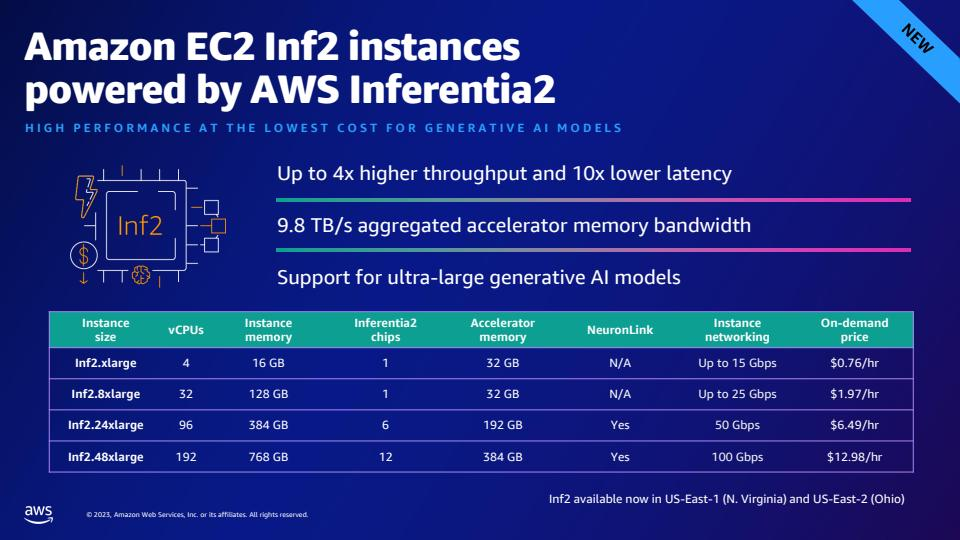

In [78]:
s3_img_path = vector_db_response.get('hits', {}).get('hits')[0].get('_source').get('image_path')
logger.info(f"going to answer the question=\"{question}\" using the image \"{s3_img_path}\"")

!aws s3 cp {s3_img_path} .
local_img_path = os.path.basename(s3_img_path)
Image(filename=local_img_path) 

In [79]:
slide_text = vector_db_response.get('hits', {}).get('hits')[0].get('_source').get('slide_text')

In [80]:
llm_response = get_llm_response(bedrock, question, slide_text)
print(llm_response)

Based on the information provided in the summary, the key performance comparison numbers given for the Amazon EC2 Inf2 instances compared to other instances are:

1. Up to 4x higher throughput
2. Up to 10x lower latency

The summary does not provide specific numbers comparing the Inf2 instances to other EC2 instance types. However, it highlights the throughput and latency improvements as the main performance advantages of the Inf2 instances over comparable instances for running generative AI models.


### Question 2

[2024-03-21 03:44:16,376] p7916 {base.py:259} INFO - POST https://pxq3e68n8rlteqnhl98d.us-east-1.aoss.amazonaws.com:443/slides/_search [status:200 request:0.059s]
[2024-03-21 03:44:16,383] p7916 {3947406868.py:18} INFO - received response from OpenSearch, response={
  "took": 16,
  "timed_out": false,
  "_shards": {
    "total": 0,
    "successful": 0,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 21,
      "relation": "eq"
    },
    "max_score": 0.009230784,
    "hits": [
      {
        "_index": "slides",
        "_id": "1%3A0%3AOLbeXI4B7Mf7XH6aKU-w",
        "_score": 0.009230784,
        "_source": {
          "image_path": "s3://multimodal-blog2-bucket-597703351594/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_27.jpg",
          "slide_text": "The image appears to be a slide or diagram titled 'Full stack AI/ML integration'. It illustrates the various AWS services and components involved in building and deploying artificial intell

download: s3://multimodal-blog2-bucket-597703351594/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_11.jpg to ./CMP301_TrainDeploy_E1_20230607_SPEdited_image_11.jpg


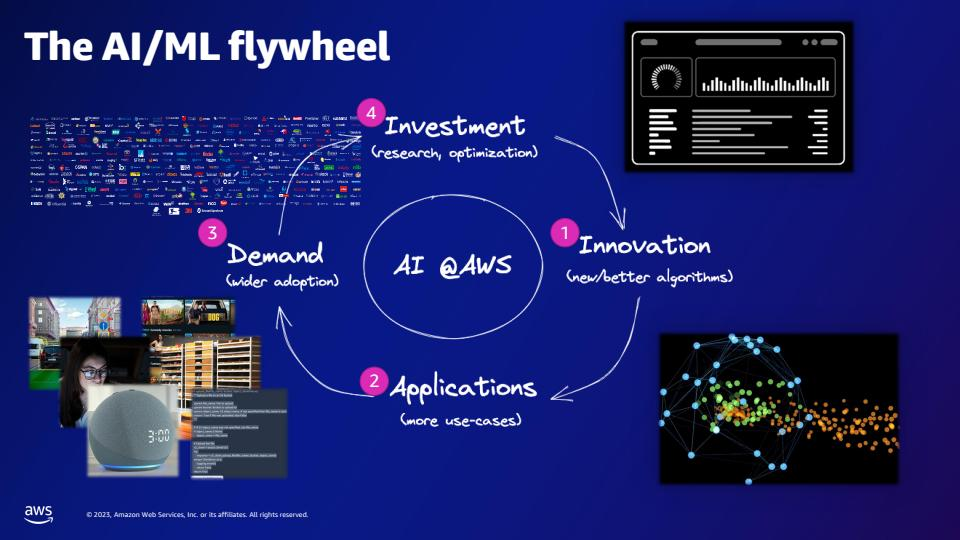

Based on the summary, the AWS AI/ML services provide a range of capabilities that fuel an AI/ML flywheel. This flywheel consists of innovation in developing new and better algorithms, enabling more use-cases and applications, driving wider adoption and demand, which in turn leads to further investment in research and optimization to drive more innovation. The AWS AI/ML services seem to offer the tools, resources, and infrastructure to support this continuous cycle of innovation, application development, adoption, and reinvestment in the field of artificial intelligence and machine learning.


In [81]:
# create prompt and convert to embeddings
question: str = "As per the AI/ML flywheel, what do the AWS AI/ML services provide?"
text_embedding = get_text_embedding(bedrock, question)

#Find the 2 most similar slide from the vector db
vector_db_response: Dict = find_similar_data(text_embedding, 2)

# download image for local notebook display
s3_img_path = vector_db_response.get('hits', {}).get('hits')[1].get('_source').get('image_path')
logger.info(f"going to answer the question=\"{question}\" using the image \"{s3_img_path}\"")

!aws s3 cp {s3_img_path} .
local_img_path = os.path.basename(s3_img_path)
display(Image(filename=local_img_path))

# Ask Claude
slide_text = vector_db_response.get('hits', {}).get('hits')[1].get('_source').get('slide_text')
llm_response = get_llm_response(bedrock, question, slide_text)
print(llm_response)

### Question 3

What about slides that contain charts and graphs? We want to see if the LLaVA model can correcly analyze a graph and pull appropriate metrics from the slide. 

[2024-03-21 03:44:22,860] p7916 {base.py:259} INFO - POST https://pxq3e68n8rlteqnhl98d.us-east-1.aoss.amazonaws.com:443/slides/_search [status:200 request:0.044s]
[2024-03-21 03:44:22,861] p7916 {3947406868.py:18} INFO - received response from OpenSearch, response={
  "took": 16,
  "timed_out": false,
  "_shards": {
    "total": 0,
    "successful": 0,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 11,
      "relation": "eq"
    },
    "max_score": 0.0051067406,
    "hits": [
      {
        "_index": "slides",
        "_id": "1%3A0%3APbbgXI4B7Mf7XH6aAU8F",
        "_score": 0.0051067406,
        "_source": {
          "image_path": "s3://multimodal-blog2-bucket-597703351594/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_13.jpg",
          "slide_text": "The image is a slide titled 'AI models are getting bigger' by AWS. It presents a chart that shows the increasing trend in the size of AI models over time, measured by the number of parame

download: s3://multimodal-blog2-bucket-597703351594/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_13.jpg to ./CMP301_TrainDeploy_E1_20230607_SPEdited_image_13.jpg


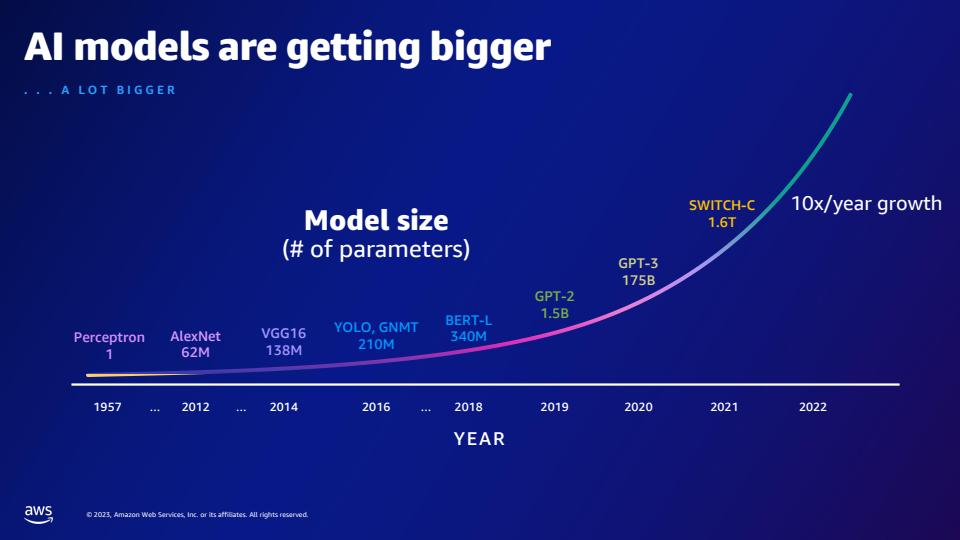

According to the information provided in the summary, GPT-3 from 2020 had 175B (175 billion) parameters, while GPT-2 from 2019 had 1.5B (1.5 billion) parameters. Therefore, the numerical difference between the parameter size of GPT-2 and GPT-3 is 173.5 billion parameters. GPT-3 has approximately 115 times more parameters than GPT-2.


In [82]:
# create prompt and convert to embeddings
question: str = "Compared to GPT-2, how many more parameters does GPT-3 have? What is the numerical difference between the parameter size of GPT-2 and GPT-3?"
text_embedding = get_text_embedding(bedrock, question)

# vector db search
vector_db_response: Dict = find_similar_data(text_embedding, 1)

# download image for local notebook display
s3_img_path = vector_db_response.get('hits', {}).get('hits')[0].get('_source').get('image_path')
logger.info(f"going to answer the question=\"{question}\" using the image \"{s3_img_path}\"")

!aws s3 cp {s3_img_path} .
local_img_path = os.path.basename(s3_img_path)
display(Image(filename=local_img_path))

# Ask Claude
slide_text = vector_db_response.get('hits', {}).get('hits')[0].get('_source').get('slide_text')
llm_response = get_llm_response(bedrock, question, slide_text)
print(llm_response)

### Question 4

How about a question that cannot be answered based on this slide deck? We want to confirm that while some slide image will be retrieved but the Claude model does not hallucinate and correctly says  "I do not know".

[2024-03-21 03:44:27,117] p7916 {base.py:259} INFO - POST https://pxq3e68n8rlteqnhl98d.us-east-1.aoss.amazonaws.com:443/slides/_search [status:200 request:0.041s]
[2024-03-21 03:44:27,120] p7916 {3947406868.py:18} INFO - received response from OpenSearch, response={
  "took": 15,
  "timed_out": false,
  "_shards": {
    "total": 0,
    "successful": 0,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 11,
      "relation": "eq"
    },
    "max_score": 0.0022159463,
    "hits": [
      {
        "_index": "slides",
        "_id": "1%3A0%3AObbeXI4B7Mf7XH6alE8B",
        "_score": 0.0022159463,
        "_source": {
          "image_path": "s3://multimodal-blog2-bucket-597703351594/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_6.jpg",
          "slide_text": "The image is a slide titled 'The road to generative AI'. The slide has a dark blue background with white and light blue text and shapes.\n\nThe slide presents a visual diagram or flowchart

download: s3://multimodal-blog2-bucket-597703351594/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_6.jpg to ./CMP301_TrainDeploy_E1_20230607_SPEdited_image_6.jpg


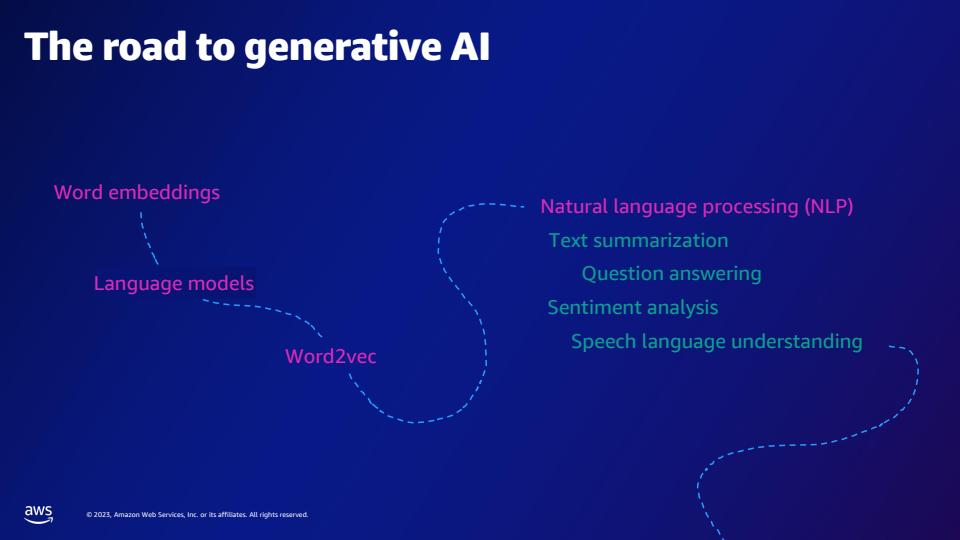

Unfortunately, the given summary does not contain any information about quarks in particle physics. The summary describes an image related to the progression of natural language processing and generative AI technologies, but it does not mention anything about particle physics or the concept of quarks.


In [83]:
# create prompt and convert to embeddings
question: str = "What are quarks in particle physics?"
text_embedding = get_text_embedding(bedrock, question)

# vector db search
vector_db_response: Dict = find_similar_data(text_embedding, 1)

# download image for local notebook display
s3_img_path = vector_db_response.get('hits', {}).get('hits')[0].get('_source').get('image_path')
logger.info(f"going to answer the question=\"{question}\" using the image \"{s3_img_path}\"")

!aws s3 cp {s3_img_path} .
local_img_path = os.path.basename(s3_img_path)
display(Image(filename=local_img_path))

# Ask Claude
slide_text = vector_db_response.get('hits', {}).get('hits')[0].get('_source').get('slide_text')
llm_response = get_llm_response(bedrock, question, slide_text)
print(llm_response)

## Clean Up
